# Install / Import Library

In [1]:
pip install tensorflow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [80]:
pip install optuna

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.2 MB/s eta 0:00:00a 0:00:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [69]:
pip install keras_tuner


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 5.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 7.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 5.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [1]:
import tensorflow as tf

2025-06-29 16:56:48.399987: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
import transformers

# begin Training With LSTM 

In [ ]:
# create LLM
def create_llm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [5]:
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/airline_passengers.csv')
df = pd.read_csv('Dataset/Historical/HistoricalData.csv')
df = df.drop(['Unnamed: 0', 'date'], axis=1)

In [7]:
features = ['price', 'open', 'high', 'low', 'volume', 'change']
target = 'price'

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

y = df[target].values
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

Sequence creator

In [9]:
def create_sequence(X, y, timesteps=5, step_ahead=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps - step_ahead + 1):
        X_seq.append(X[i:i + timesteps])
        y_seq.append(y[i + timesteps + step_ahead - 1])
    return np.array(X_seq), np.array(y_seq)

Model Builder

In [10]:
def build_model(timesteps, feature_dim):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(timesteps, feature_dim)))
    #model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

Train-Evaluate-Plot Pipeline

In [11]:
def train_predict_plot(step_ahead, label):
    timesteps = 5
    X_seq, y_seq = create_sequence(X_scaled, y_scaled, timesteps, step_ahead)

    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    model = build_model(timesteps, X_train.shape[2])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n{label} Forecast:")
    print(f"Test MAE: {mae:.2f}")

    y_pred = model.predict(X_test)

    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'LSTM {label} Prediction')
    plt.xlabel('Time')
    plt.ylabel('Bitcoin Price')
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Next Day Forecast:
Test MAE: 0.58
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


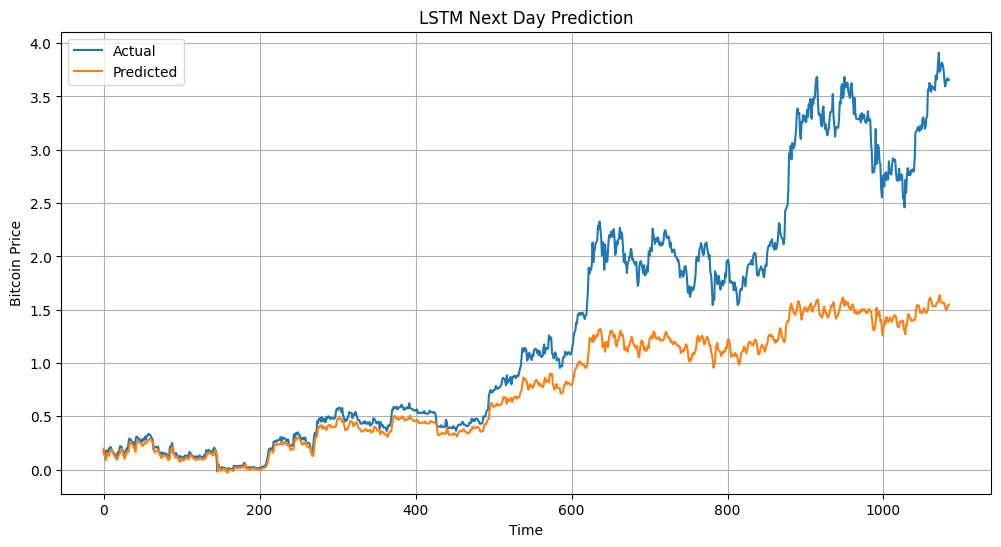

In [11]:
train_predict_plot(step_ahead=1, label='Next Day')

At first it good, but it looks like model can't catch up with bitcoin's absurds volatility


Next Week Forecast:
Test MAE: 0.76
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


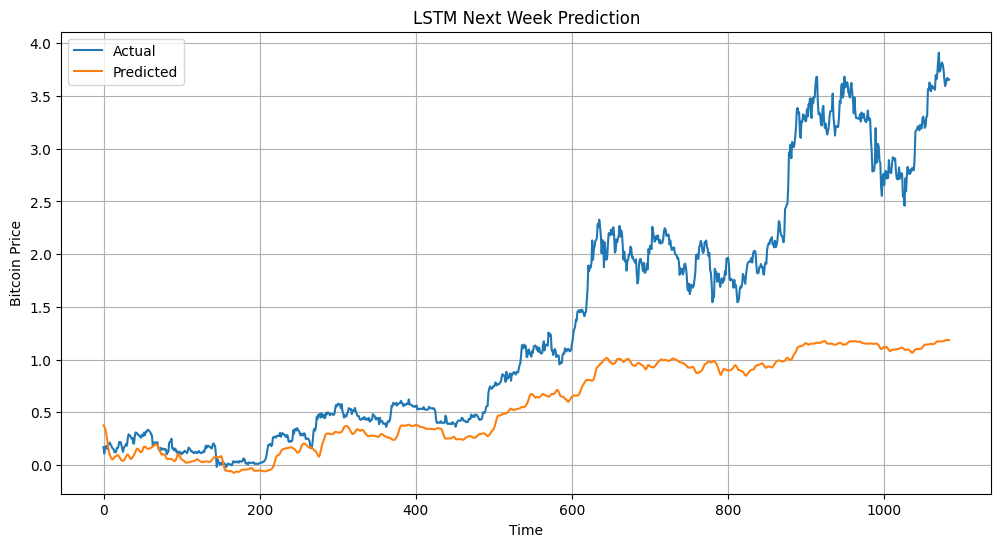

In [44]:
train_predict_plot(step_ahead=7, label='Next Week')


Next Month Forecast:
Test MAE: 0.76
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


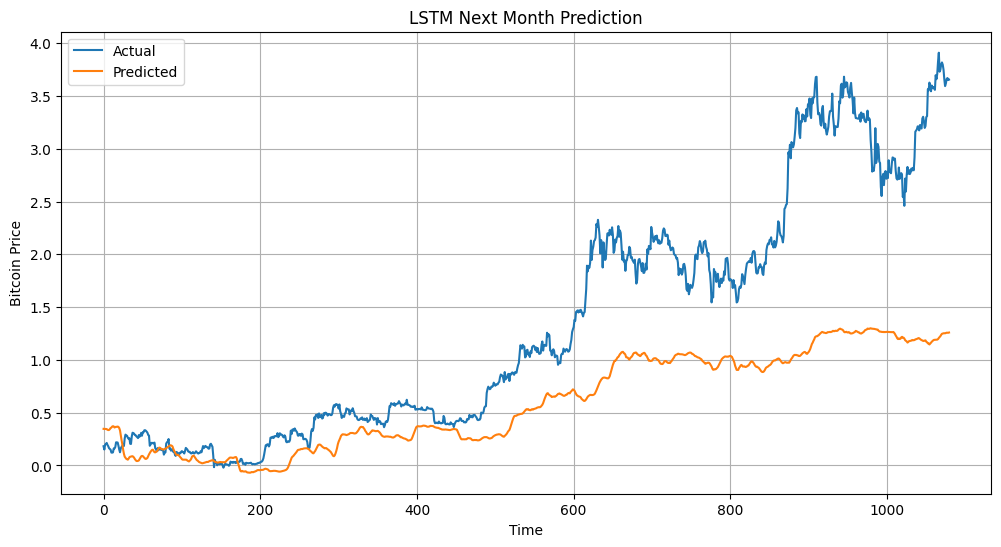

In [45]:
train_predict_plot(step_ahead=30, label='Next Month')


Next Year Forecast:
Test MAE: 1.25
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


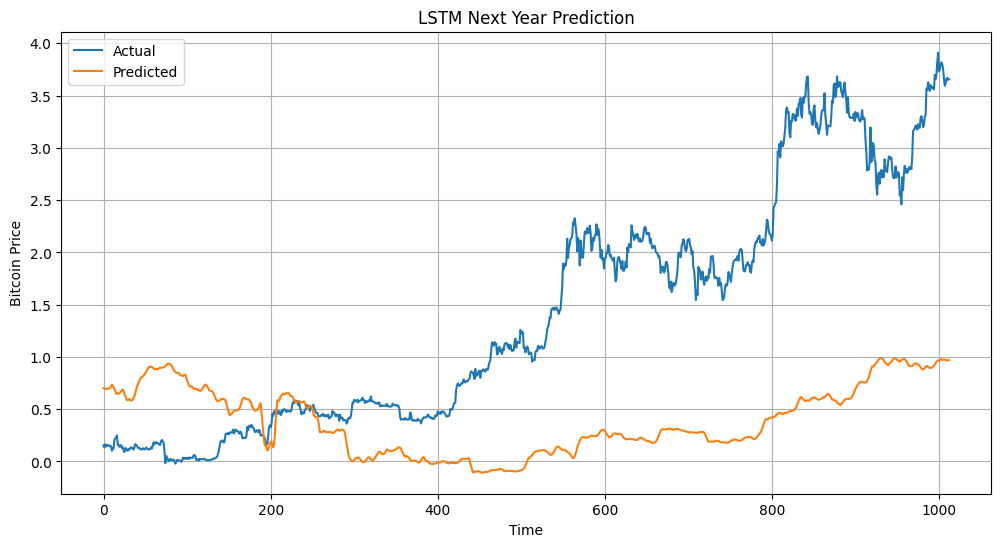

In [46]:
train_predict_plot(step_ahead=365, label='Next Year')

# Tuning

In [1]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner import RandomSearch

2025-06-25 17:06:46.292289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
timesteps = 5
X_seq, y_seq = create_sequence(X_scaled, y_scaled, timesteps)

split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [76]:
def display_predictions(future_days, label):
    y_pred = recursive_multi_step_prediction(best_model, X_test, future_steps=future_days)
    print(f"predicted{label}:")
    print(y_pred)
    

In [77]:
display_predictions(1, ' Next Day')

predicted Next Day:
[48132.09]


/var/folders/jg/syzw72_n52x0x5b9sggw57x80000gn/T/ipykernel_27716/4050928153.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_entry[-1, 0] = pred  # Overwrite 'price' with predicted price


In [78]:
display_predictions(7, ' Next Week')

/var/folders/jg/syzw72_n52x0x5b9sggw57x80000gn/T/ipykernel_27716/4050928153.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_entry[-1, 0] = pred  # Overwrite 'price' with predicted price


predicted Next Week:
[48132.09  48702.652 48862.633 48455.094 46892.84  42222.76  42250.72 ]


# New Pipeline

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

In [14]:
# ================== Preprocessing Function ==================
def create_sequences(data, window_size, forecast_horizon, mode='sliding'):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])
        if mode == 'sliding':
            y.append(data[i+window_size:i+window_size+forecast_horizon])
        elif mode == 'recursive':
            y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [15]:
# ================== Model Builder ==================
def build_model(input_shape, forecast_horizon=1, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(forecast_horizon))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    return model

In [16]:
def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Bitcoin Price (Scaled)')
    plt.legend()
    plt.show()

In [17]:
# ================== Pipeline ==================
def forecasting_pipeline(data, window_size=60, forecast_horizon=7, mode='sliding'):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    X, y = create_sequences(data_scaled, window_size, forecast_horizon, mode)

    if mode == 'recursive':
        y = y.reshape(-1, 1)

    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    model = build_model((X_train.shape[1], 1), forecast_horizon if mode == 'sliding' else 1)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
        ModelCheckpoint('best_model.keras', save_best_only=True)
    ]

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )

    if mode == 'recursive':
        y_pred = []
        input_seq = X_test[0]
        for _ in range(len(y_test)):
            pred = model.predict(input_seq.reshape(1, window_size, 1), verbose=0)
            y_pred.append(pred[0, 0])
            input_seq = np.append(input_seq[1:], pred[0, 0])

        y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
        y_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    else:
        y_pred = model.predict(X_test)
        y_pred = scaler.inverse_transform(y_pred.flatten().reshape(-1, 1)).flatten()
        y_actual = scaler.inverse_transform(y_test.flatten().reshape(-1, 1)).flatten()

    plot_predictions(y_actual, y_pred, f'{mode.title()} Window Prediction')
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    test_mae = mae_metric(y_actual, y_pred).numpy()
    print(f'Test MAE: {test_mae:.4f}')


/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 7.7695e-04 - mae: 0.0183 - val_loss: 0.0107 - val_mae: 0.0782 - learning_rate: 0.0010
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 1.0064e-04 - mae: 0.0058 - val_loss: 0.0075 - val_mae: 0.0653 - learning_rate: 0.0010
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 8.5883e-05 - mae: 0.0054 - val_loss: 0.0093 - val_mae: 0.0738 - learning_rate: 0.0010
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 6.8170e-05 - mae: 0.0047 - val_loss: 0.0064 - val_mae: 0.0589 - learning_rate: 0.0010
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 6.3610e-05 - mae: 0.0045 - val_loss: 0.0072 - val_mae: 0.0637 - learning_rate: 0.0010
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 6.3204e-05 - mae: 0.0043 - val_loss: 0.0075 - val_mae: 0.0652 - learning_rate: 0.0010
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 6.4765e-05 - mae: 0.0045 - val_loss: 0.0073 - val_mae: 0.0650 - 

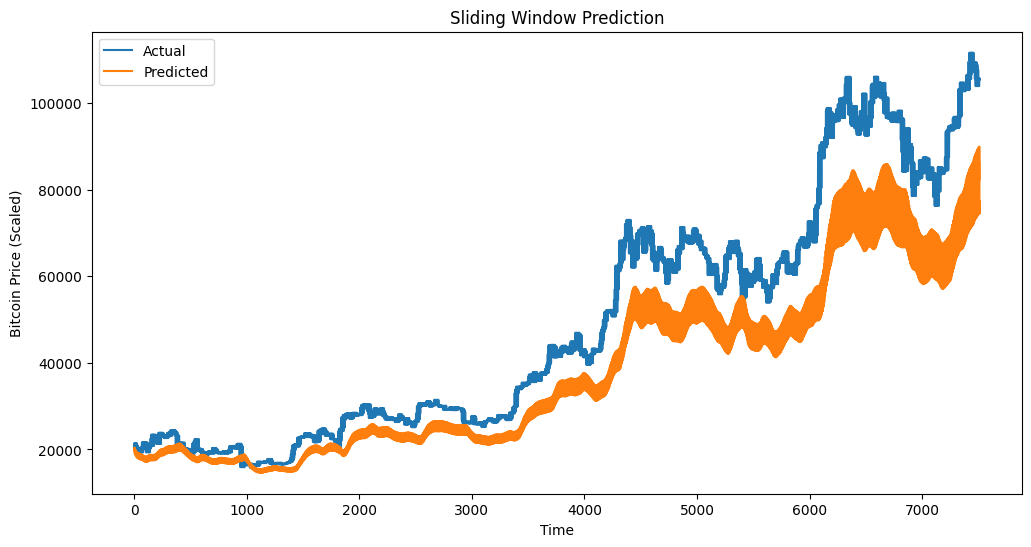

Test MAE: 10974.7441
Epoch 1/200


/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 6.4914e-04 - mae: 0.0176 - val_loss: 0.0044 - val_mae: 0.0511 - learning_rate: 0.0010
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 5.7556e-05 - mae: 0.0041 - val_loss: 0.0062 - val_mae: 0.0616 - learning_rate: 0.0010
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 5.0471e-05 - mae: 0.0039 - val_loss: 0.0042 - val_mae: 0.0492 - learning_rate: 0.0010
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 4.8066e-05 - mae: 0.0039 - val_loss: 0.0059 - val_mae: 0.0604 - learning_rate: 0.0010
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 6.2146e-05 - mae: 0.0047 - val_loss: 0.0048 - val_mae: 0.0524 - learning_rate: 0.0010
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 4.1441e-05 - mae: 0.0035 - val_loss: 0.0033 - val_mae: 0.0424 - learning_rate: 0.0010
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 4.3691e-05 - mae: 0.0037 - val_loss: 0.0043 - val_mae: 0.0494 - learning_rat

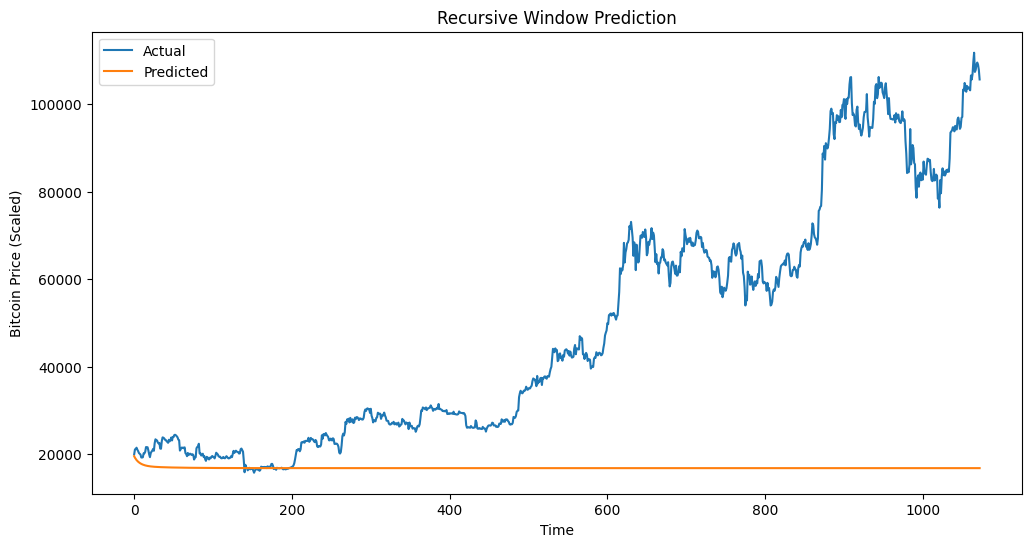

Test MAE: 32071.9395


In [18]:
data = pd.read_csv('Dataset/Historical/HistoricalData.csv')['price'].values
forecasting_pipeline(data, window_size=60, forecast_horizon=7, mode='sliding')
forecasting_pipeline(data, window_size=60, forecast_horizon=7, mode='recursive')

In [20]:
# ================== Prediksi Harga Besok ==================
def predict_next_day(data, window_size=60, mode='sliding'):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    X, y = create_sequences(data_scaled, window_size, forecast_horizon=1, mode=mode)

    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test = X[split:]

    model = build_model((X_train.shape[1], 1), forecast_horizon=1)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
        ModelCheckpoint('best_model.keras', save_best_only=True)
    ]

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )

    # Prediksi harga besok menggunakan data terakhir dari X_test
    last_sequence = X_test[-1].reshape(1, window_size, 1)
    next_day_prediction = model.predict(last_sequence, verbose=0)
    next_day_price = scaler.inverse_transform(next_day_prediction).flatten()[0]

    print(f"Prediksi Harga Besok: {next_day_price:.2f}")
    return next_day_price

# ================== Panggil Fungsi ==================
data = pd.read_csv('Dataset/Historical/HistoricalData.csv')['price'].values
next_day_price = predict_next_day(data, window_size=60, mode='sliding')

/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 5.8745e-04 - mae: 0.0155 - val_loss: 0.0035 - val_mae: 0.0428 - learning_rate: 0.0010
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 5.7437e-05 - mae: 0.0044 - val_loss: 0.0064 - val_mae: 0.0620 - learning_rate: 0.0010
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 5.7527e-05 - mae: 0.0042 - val_loss: 0.0035 - val_mae: 0.0431 - learning_rate: 0.0010
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 3.8741e-05 - mae: 0.0036 - val_loss: 0.0035 - val_mae: 0.0433 - learning_rate: 0.0010
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 3.5923e-05 - mae: 0.0033 - val_loss: 0.0033 - val_mae: 0.0430 - learning_rate: 0.0010
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 4.6564e-05 - mae: 0.0040 - val_loss: 0.0033 - val_mae: 0.0425 - learning_rate: 0.0010
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 4.2105e-05 - mae: 0.0038 - val_loss: 0.0029 - val_mae: 0.0394 - 